In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

In [18]:
df = pd.read_csv("/content/datapre.csv")

# Logistic Regression

In [30]:
# Keep NaNs in death_age and create the missing indicator
df['death_age_missing'] = df['death_age'].isna().astype(int)

features = [
    'gender', 'insurance', 'language', 'religion', 'marital_status',
    'ethnicity', 'admission_count', 'los_adm', 'last_admission_location',
    'last_admission_type', 'adm_age', 'icu_count', 'icu_age',
    'los_icu', 'mechanical_ventilation', 'VASOPRESSOR_USE'
]

X = df[features]
y = df['hospital_expired']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === Preprocessing ===
numeric_features = ['admission_count', 'los_adm', 'adm_age', 'icu_count', 'icu_age', 'los_icu']
binary_features = ['mechanical_ventilation', 'VASOPRESSOR_USE']
categorical_features = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
                        'last_admission_location', 'last_admission_type']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='passthrough')  # for binary columns

# === Logistic Regression Pipeline ===
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['admission_count',
                                                                          'los_adm',
                                                                          'adm_age',
                                                                          'icu_count',
                                                                          'icu_age',
                                                                          'los_icu']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['gender',
                                                                          'insurance',
                                                                          'language',
                                                                          'religion',
                                                                          'marital_status',
                                                                          'ethnicity',
                                                                          'last_admission_location',
                                                                          'last_admission_type'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1, param_grid={'classifier__C': [0.01, 0.1, 1, 10]},
             scoring='roc_auc')

Best Params: {'classifier__C': 1}
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.74      0.84      6590
           1       0.26      0.79      0.39       738

    accuracy                           0.75      7328
   macro avg       0.61      0.77      0.61      7328
weighted avg       0.90      0.75      0.80      7328



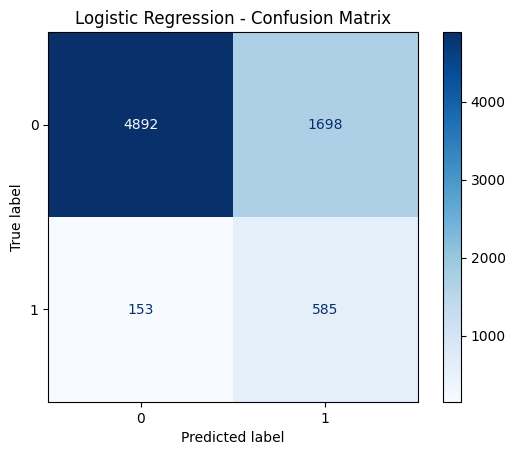

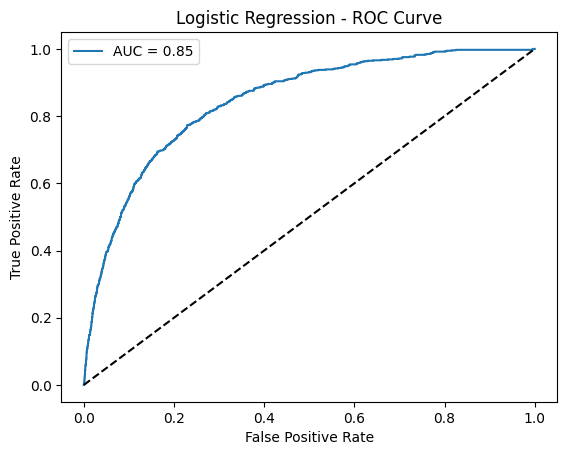

Saved random forest model as 'logistice_regression_model'


In [31]:
# === Evaluation ===
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Best Params:", grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression - ROC Curve")
plt.legend()
plt.show()

# Save model
joblib.dump(best_model, 'logistice_regression_model')
print("Saved random forest model as 'logistice_regression_model'")

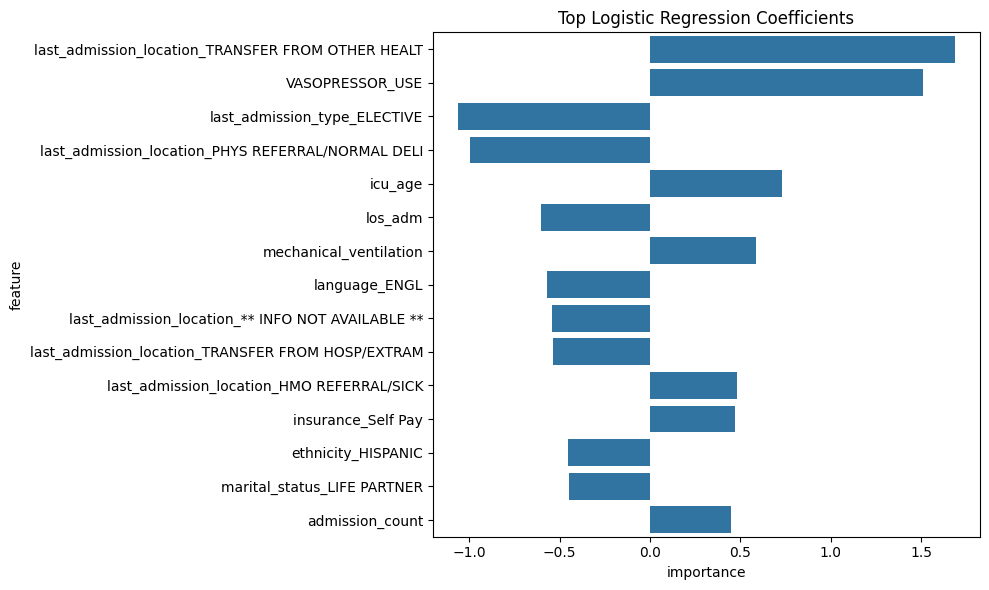

In [32]:
# Feature Importances (coefficients)
feature_names = (
    grid.best_estimator_.named_steps['preprocessor']
    .transformers_[0][1].named_steps['scaler']
    .get_feature_names_out(numeric_features)
    .tolist() +
    grid.best_estimator_.named_steps['preprocessor']
    .transformers_[1][1].named_steps['onehot']
    .get_feature_names_out(categorical_features).tolist() +
    binary_features
)

coef = best_model.named_steps['classifier'].coef_[0]
coef_df = pd.DataFrame({'feature': feature_names, 'importance': coef})
coef_df = coef_df.sort_values(by='importance', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=coef_df.head(15))
plt.title("Top Logistic Regression Coefficients")
plt.tight_layout()
plt.show()

In [35]:
# === Feature Selection based on Coefficients ===
top_features_lr = coef_df.head(15)['feature'].tolist()

# === Create Final Dataset with Top 15 Features ===
X_all_transformed_lr = best_model.named_steps['preprocessor'].transform(X)

# Get the transformed feature names
onehot_features_lr = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names_lr = numeric_features + list(onehot_features_lr) + binary_features

# Create DataFrame and keep only top 15 features
X_all_df_lr = pd.DataFrame(X_all_transformed_lr, columns=all_feature_names_lr)
X_top15_df_lr = X_all_df_lr[top_features_lr].copy()

# Add subject_id and hospital_expired
X_top15_df_lr['subject_id'] = df['subject_id'].values
X_top15_df_lr['hospital_expired'] = df['hospital_expired'].values

# Reorder columns: subject_id, hospital_expired, top features
cols_lr = ['subject_id', 'hospital_expired'] + top_features_lr
X_top15_df_lr = X_top15_df_lr[cols_lr]

# Save the new dataset
X_top15_df_lr.to_csv('top15_lr_features_dataset.csv', index=False)
print("Top 15 feature dataset saved as 'top15_lr_features_dataset.csv'")

Top 15 feature dataset saved as 'top15_lr_features_dataset.csv'


# Random Forests

In [36]:
# Keep NaNs in death_age and create the missing indicator
df['death_age_missing'] = df['death_age'].isna().astype(int)

features = [
    'gender', 'insurance', 'language', 'religion', 'marital_status',
    'ethnicity', 'admission_count', 'los_adm', 'last_admission_location',
    'last_admission_type', 'adm_age', 'icu_count', 'icu_age',
    'los_icu', 'mechanical_ventilation', 'VASOPRESSOR_USE'
]

X = df[features]
y = df['hospital_expired']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === Preprocessing ===
numeric_features = ['admission_count', 'los_adm', 'adm_age', 'icu_count', 'icu_age', 'los_icu']
binary_features = ['mechanical_ventilation', 'VASOPRESSOR_USE']
categorical_features = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
                        'last_admission_location', 'last_admission_type']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='passthrough')

# === Random Forest Pipeline ===
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['admission_count',
                                                                          'los_adm',
                                                                          'adm_age',
                                                                          'icu_count',
                                                                          'icu_age',
                                                                          'los_icu']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one...
                                                                          'marital_status',
                                                                          'ethnicity',
                                                                          'last_admission_location',
                                                                          'last_admission_type'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 10, None],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='roc_auc')

Best Params: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      6590
           1       0.70      0.50      0.58       738

    accuracy                           0.93      7328
   macro avg       0.82      0.74      0.77      7328
weighted avg       0.92      0.93      0.92      7328



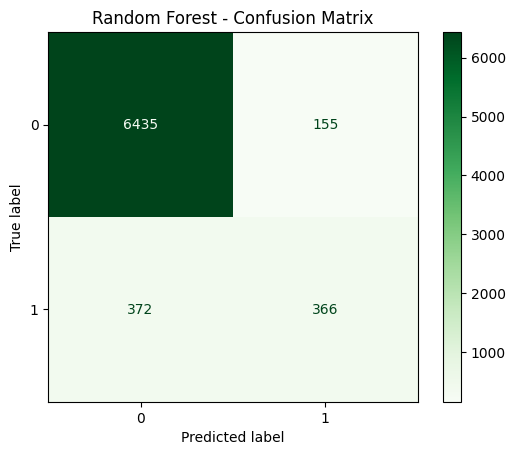

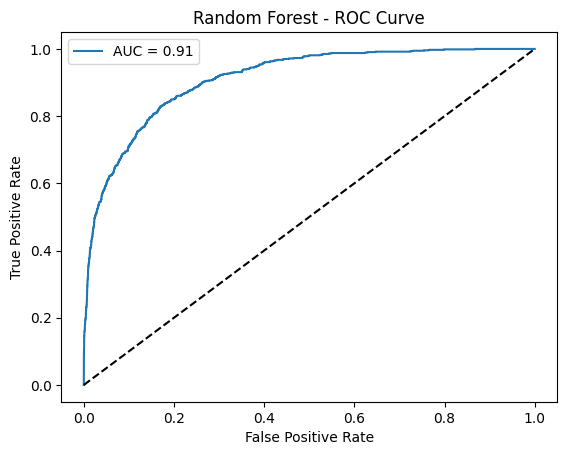

Saved random forest model as 'random_forest_model'


In [37]:
# === Evaluation ===
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Best Params:", grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title("Random Forest - Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - ROC Curve")
plt.legend()
plt.show()

# Save model
joblib.dump(best_model, 'random_forest_model')
print("Saved random forest model as 'random_forest_model'")

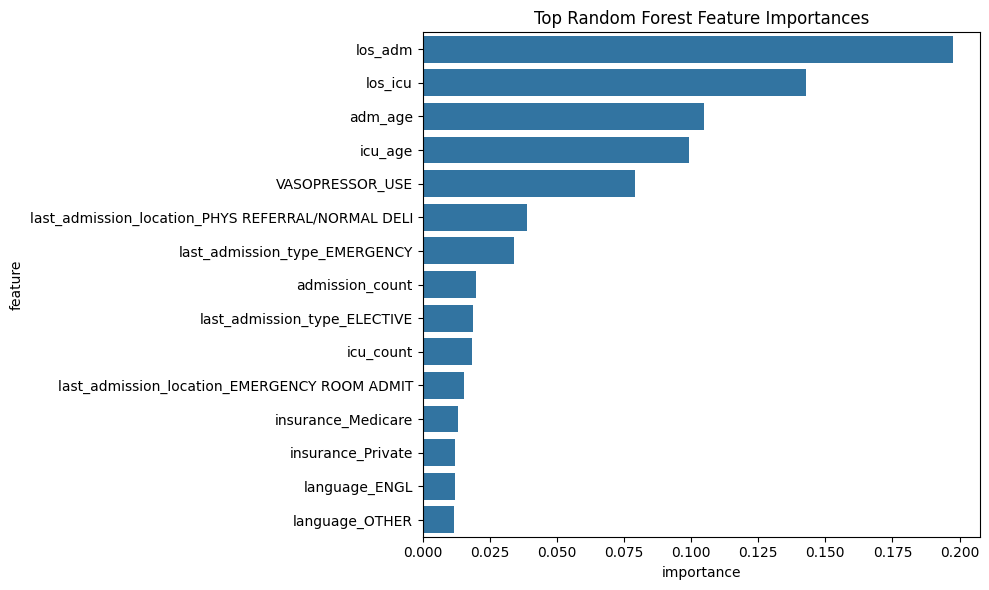

In [38]:
# Feature Importances
onehot_features = grid.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(onehot_features) + binary_features

importances = best_model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(15))
plt.title("Top Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [39]:
# select Top 15 features
top_features = importance_df.head(15)['feature'].tolist()

# Transform the entire dataset using the same preprocessing pipeline
X_all_transformed = best_model.named_steps['preprocessor'].transform(X)

# Get all feature names (in the same order as the transformed columns)
onehot_features = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(onehot_features) + binary_features

# transform to DataFrame and keep Top 15 features
X_all_df = pd.DataFrame(X_all_transformed, columns=all_feature_names)
X_top15_df = X_all_df[top_features].copy()

# add subject_id and hospital_expired
X_top15_df['subject_id'] = df['subject_id'].values
X_top15_df['hospital_expired'] = df['hospital_expired'].values

cols = ['subject_id', 'hospital_expired'] + top_features
X_top15_df = X_top15_df[cols]

# save dataset in CSV
X_top15_df.to_csv('/content/top15_rf_features_dataset.csv', index=False)
print("Top 15 feature dataset saved as 'top15_rf_features_dataset.csv' in Google Colab.")

Top 15 feature dataset saved as 'top15_rf_features_dataset.csv' in Google Colab.


In [41]:
# find common features

# Load the datasets
lr_df = pd.read_csv('/content/top15_lr_features_dataset.csv')
rf_df = pd.read_csv('/content/top15_rf_features_dataset.csv')

# Find the common columns
common_columns = lr_df.columns.intersection(rf_df.columns)
common_columns

Index(['subject_id', 'hospital_expired', 'VASOPRESSOR_USE',
       'last_admission_type_ELECTIVE',
       'last_admission_location_PHYS REFERRAL/NORMAL DELI', 'icu_age',
       'los_adm', 'language_ENGL', 'admission_count'],
      dtype='object')